In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.datasets import mnist

# Load MNIST data
(x_train, _), (x_test, _) = mnist.load_data()
x_train = x_train.astype("float32") / 255.0
x_test = x_test.astype("float32") / 255.0
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)


11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [2]:
latent_dim = 2  # Dimension of latent space

In [3]:
# Encoder
inputs = layers.Input(shape=(28, 28, 1))
x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(inputs)
x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Flatten()(x)
x = layers.Dense(16, activation="relu")(x)
z_mean = layers.Dense(latent_dim)(x)
z_log_var = layers.Dense(latent_dim)(x)

In [4]:
def sampling(args):
    z_mean, z_log_var = args
    batch = tf.shape(z_mean)[0]
    dim = tf.shape(z_mean)[1]
    epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
    return z_mean + tf.exp(0.5 * z_log_var) * epsilon


In [5]:
z = layers.Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])

In [6]:
encoder = models.Model(inputs, [z_mean, z_log_var, z], name="encoder")

In [7]:
# Decoder
latent_inputs = layers.Input(shape=(latent_dim,))
x = layers.Dense(7 * 7 * 64, activation="relu")(latent_inputs)
x = layers.Reshape((7, 7, 64))(x)
x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
outputs = layers.Conv2DTranspose(1, 3, activation="sigmoid", padding="same")(x)

In [8]:
decoder = models.Model(latent_inputs, outputs, name="decoder")

In [9]:
# VAE Model
outputs = decoder(encoder(inputs)[2])
vae = models.Model(inputs, outputs, name="vae")

In [10]:
# Custom loss layer to compute reconstruction and KL divergence losses
class VAE_LossLayer(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(VAE_LossLayer, self).__init__(**kwargs)

    def call(self, inputs, outputs, z_mean, z_log_var):
        reconstruction_loss = tf.reduce_mean(tf.keras.losses.binary_crossentropy(inputs, outputs)) * 28 * 28
        kl_loss = 1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)
        kl_loss = tf.reduce_mean(kl_loss) * -0.5
        total_loss = reconstruction_loss + kl_loss
        self.add_loss(total_loss)
        return outputs

# Apply the custom loss layer
outputs = VAE_LossLayer()(inputs, outputs, z_mean, z_log_var)
vae = models.Model(inputs, outputs, name="vae")
vae.compile(optimizer='adam')


In [11]:
# Train the VAE
history = vae.fit(x_train, x_train, epochs=20, batch_size=128, validation_data=(x_test, x_test))


Epoch 1/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 19s 19ms/step - loss: 267.8895 - val_loss: 185.7054
Epoch 2/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 175.7691 - val_loss: 162.8929
Epoch 3/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 161.2643 - val_loss: 157.9252
Epoch 4/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 157.7998 - val_loss: 157.0158
Epoch 5/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 155.8370 - val_loss: 154.2242
Epoch 6/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 154.6400 - val_loss: 153.4189
Epoch 7/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 153.4292 - val_loss: 152.2715
Epoch 8/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 152.6133 - val_loss: 151.6368
Epoch 9/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 151.5138 - val_loss: 151.9315
Epoch 10/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 150.7900 - val_loss: 150.6621
Epoch 11/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 150.4940 - val_loss: 150.2020
Epoch 

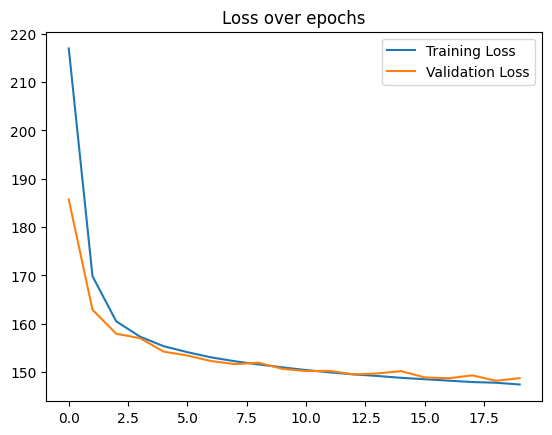

In [12]:
# Plotting the loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title("Loss over epochs")
plt.show()

In [13]:
# Print final MSE and other errors
mse = np.mean(history.history['loss'])
print(f"Final Training MSE: {mse}")
val_mse = np.mean(history.history['val_loss'])
print(f"Final Validation MSE: {val_mse}")

Final Training MSE: 155.48316116333007
Final Validation MSE: 153.57003173828124


In [24]:
@tf.keras.utils.register_keras_serializable()
def sampling(args):
    z_mean, z_log_var = args
    batch = tf.shape(z_mean)[0]
    dim = tf.shape(z_mean)[1]
    epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
    return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [27]:
import tensorflow as tf

# Ensure the class is properly registered
@tf.keras.utils.register_keras_serializable()
class VAE_LossLayer(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(VAE_LossLayer, self).__init__(**kwargs)

    def call(self, inputs):
        # Implement your custom loss logic here
        return inputs  # For demonstration purposes

    def get_config(self):
        config = super(VAE_LossLayer, self).get_config()
        return config

# Register the class manually in custom_objects
custom_objects = {'VAE_LossLayer': VAE_LossLayer}

In [28]:
vae.save('vae_mnist.keras')

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 716ms/step


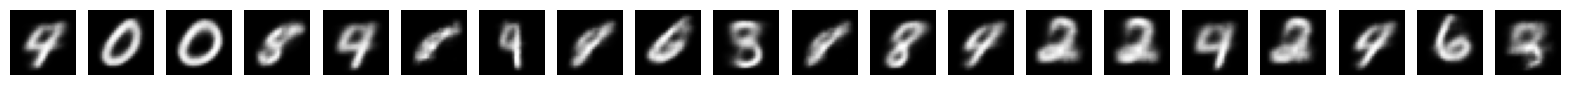

In [32]:
# Generate images using the decoder
z_sample = np.random.normal(size=(20, latent_dim))
generated_images = decoder.predict(z_sample)

# Plot generated images
plt.figure(figsize=(20, 8))
for i in range(20):
    plt.subplot(1, 20, i + 1)
    plt.imshow(generated_images[i, :, :, 0], cmap='gray')
    plt.axis('off')
plt.show()